## Setup

Load the dataframe, have helper methods for getting document lengths, term frequency stats, etc

In [1]:
import json
rawfile = open('doc_term_frequency.json')
terms = [json.loads(line) for line in rawfile]

In [2]:
import pandas as pd
import numpy as np 

df = pd.DataFrame(terms)

total_terms = df['count'].sum()  # Sum of term frequencies
num_documents = df['url'].nunique()  # Total number of unique documents
non_empty_documents = df[df['count'] > 0]['url'].nunique()  # Documents with at least one term
unique_terms = df['term'].nunique()  # Number of unique terms (including empty terms if present)

stats = {
    'total_terms': total_terms,
    'num_documents': num_documents,
    'non_empty_documents': non_empty_documents,
    'unique_terms': unique_terms
}

print(stats)

{'total_terms': 18387836, 'num_documents': 17337, 'non_empty_documents': 17337, 'unique_terms': 147802}


In [3]:
doc_lengths = df.groupby("url")["count"].sum().reset_index()
doc_lengths.rename(columns={"count": "doc_length"}, inplace=True)

In [4]:
def get_doc_length(url):
    result = doc_lengths[doc_lengths['url'] == url]
    if not result.empty:
        return result['doc_length'].values[0]
    else:
        return 0

def get_term_frequencies(term):
    # Document frequency: Number of documents containing the term
    document_frequency = df[df['term'] == term]['url'].nunique()
    # Collection frequency: Sum of the term counts across all documents
    collection_frequency = df[df['term'] == term]['count'].sum()
    
    return document_frequency, collection_frequency

def get_postings_list(term):
    # Filter rows for the specific term
    term_rows = df[df['term'] == term]
    
    postings_list = []
    for _, row in term_rows.iterrows():
        postings_list.append({
            'url': row['url'],
            'tf': row['count'],
        })
    return postings_list

In [22]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def process_query(query):
    return [
    stemmer.stem(word.lower()) 
    for word in word_tokenize(query) 
    if word.isalnum() and word.lower() not in stop_words
]

In [23]:
process_query('what is the 49th state of USA?')

['49th', 'state', 'usa']

## BM25

In [8]:
import math
from collections import defaultdict


def calculate_bm25(query, df, doc_lengths, k1=1.5, b=0.75):
    query_terms = process_query(query)  # Tokenize and process the query
    N = len(doc_lengths)  # Total number of documents in the collection
    total_doc_length = doc_lengths['doc_length'].sum()
    num_documents = doc_lengths['url'].nunique()
    avg_doc_length = total_doc_length / num_documents
    doc_scores = defaultdict(float)  # Dictionary to store scores for each document

    for term in query_terms:
        # Step 1: Compute IDF for the term
        df_t = len(df[df['term'] == term]) 
        idf_t = math.log((N - df_t + 0.5) / (df_t + 0.5) + 1.0)

        # Step 2: Get the posting list for the term
        term_postings = get_postings_list(term)

        for posting in term_postings:
            url = posting['url']
            term_frequency = posting['tf']

            # Step 3: Get document length
            doc_length = doc_lengths.get(url, 0)

            # Step 4: Apply BM25 formula to calculate the score for this document
            term_freq_saturation = (term_frequency * (k1 + 1)) / (term_frequency + k1 * (1 - b + b * (doc_length / avg_doc_length)))
            score = idf_t * term_freq_saturation

            # Accumulate the score for this document
            doc_scores[url] += score

    # Step 5: Sort the documents by score (higher score means more relevant)
    top_docs = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)

    return top_docs

In [9]:
calculate_bm25("49th state of the US", df=df, doc_lengths=doc_lengths)[0:5]

[('https://archive.org/details/alaskahistoryof40000nask', 14.647105111254836),
 ('https://books.google.com/books?id=-xhQl1WDWa0C&pg=PA330',
  14.647105111254836),
 ('https://archive.org/details/1959-01-05_49th_Star_Alaska_Statehood',
  14.647105111254836),
 ('https://books.google.com/books?id=-xhQl1WDWa0C&q=Hickel+worked+with+the+AFN%2C+negotiating+between+Natives+and+Alaska&pg=PA205',
  14.647105111254836),
 ('https://books.google.com/books?id=-xhQl1WDWa0C&q=Hickel+worked+with+the+AFN,+negotiating+between+Natives+and+Alaska',
  14.647105111254836)]

In [10]:
calculate_bm25("wildlife of Alaska", df=df, doc_lengths=doc_lengths)[0:10]

[('http://www.explorenorth.com/library/weekly/aa110599.htm',
  12.275431103207435),
 ('https://en.wikibooks.org/wiki/History_of_Alaska/Printable_version',
  12.261681391982926),
 ('https://en.wikipedia.org/wiki/Alaska_Department_of_Fish_and_Game',
  12.161598284023674),
 ('https://en.wikibooks.org/wiki/History_of_Alaska/Alaska_in_US_Popular_Culture_(1867-present)',
  12.149113705828768),
 ('https://en.wikipedia.org/wiki/Alaska_Peninsula_National_Wildlife_Refuge',
  12.124545757279304),
 ('https://en.wikipedia.org/wiki/Sports_in_Alaska', 12.098618866972798),
 ('https://en.wikipedia.org/wiki/Alaska#Cities,_towns_and_boroughs',
  12.098618866972798),
 ('https://en.wikipedia.org/wiki/Education_in_Alaska', 12.098618866972798),
 ('https://en.wikipedia.org/wiki/Alaskan', 12.098618866972798),
 ('https://en.wikipedia.org/wiki/Alaska#Statehood', 12.098618866972798)]

## Getting Manual Relevance Feedback (Generating test sets)

In [11]:
test_queries = [
    {
        "title": "History of Alaska",
        "description": "What is the history of Alaska?",
        "narrative": "The user is looking for an overview of Alaska's history, including its indigenous cultures, exploration by Russians, and eventual statehood. Relevant results should include key events, timelines, and cultural significance."
    },
    {
        "title": "Impact of Klondike Gold Rush",
        "description": "What was the impact of the Klondike Gold Rush?",
        "narrative": "The user wants to understand the social, economic, and environmental impact of the Klondike Gold Rush. Relevant results should mention its effect on migration, economy, and indigenous communities."
    },
    {
        "title": "Alaska Purchase reasons",
        "description": "Why did the United States purchase Alaska from Russia?",
        "narrative": "The user is seeking reasons behind the Alaska Purchase, including geopolitical, economic, and strategic motivations. Relevant results should discuss the historical context and negotiations of the purchase."
    },
    {
        "title": "Alaska’s dominant industries",
        "description": "What industries dominate Alaska’s economy today?",
        "narrative": "The user is interested in knowing about Alaska’s current leading industries, such as oil, tourism, fishing, and mining. Relevant results should provide statistics and examples of these industries' contributions to the economy."
    },
    {
        "title": "Climate change in Alaska",
        "description": "How has climate change affected Alaska’s environment and history?",
        "narrative": "The user is looking for information on the impact of climate change on Alaska’s natural environment, wildlife, permafrost, and indigenous communities. Relevant results should provide examples of environmental and societal changes."
    },
    {
        "title": "Immediate consequences of Alaska Purchase",
        "description": "What were the immediate consequences of the Alaska Purchase?",
        "narrative": "The user is looking for outcomes that occurred immediately after the Alaska Purchase, such as changes in governance, settlement, and perceptions of the acquisition. Relevant results should highlight early reactions and developments."
    },
    {
        "title": "49th state of the US",
        "description": "Which is the 49th state of the US?",
        "narrative": "The user is looking for basic information confirming that Alaska is the 49th state of the United States. Relevant results should mention the year of statehood and its significance."
    },
    {
        "title": "Unique wildlife in Alaska",
        "description": "What are the unique wildlife species found in Alaska?",
        "narrative": "The user wants details about wildlife species that are unique to or prevalent in Alaska, such as Denali's wildlife, Arctic species, and marine life. Relevant results should include specific examples and their habitats."
    },
    {
        "title": "Challenges during Klondike Gold Rush",
        "description": "What challenges did miners face during the Klondike Gold Rush?",
        "narrative": "The user is seeking information on hardships miners encountered during the Klondike Gold Rush, including harsh climates, resource scarcity, and transportation issues. Relevant results should provide historical accounts and examples."
    },
    {
        "title": "Cost of Alaska Purchase",
        "description": "How much did the U.S. pay for Alaska?",
        "narrative": "The user is interested in the purchase cost of Alaska and its comparison to its perceived and actual value over time. Relevant results should include details of the transaction amount and historical significance."
    }
]

In [ ]:
feedback = {}

# Loop through all test queries
for query_data in test_queries[3:]:
    query_feedback = {}
    query_title = query_data["title"]
    query_description = query_data["description"]

    print(f"Running BM25 for query: {query_title}")
    ranked_docs = calculate_bm25(query_title, df=df, doc_lengths=doc_lengths)[0:100]
    
    print(f"Top 100 documents for query: '{query_title}'")

    # Display the top 10 documents and collect relevance feedback
    for url, score in ranked_docs:
        print(f"Document {url}: Score {score:.4f}")
        
        # Collect relevance feedback
        while True:
            try:
                relevance = int(input(f"Enter relevance feedback for {url} (0=Not Relevant, 1=Relevant, 2=Highly Relevant): "))
                if relevance not in [0, 1, 2]:
                    print("Invalid input. Please enter 0, 1, or 2.")
                else:
                    query_feedback[url] = relevance
                    break
            except ValueError:
                print("Invalid input. Please enter 0, 1, or 2.")

    print(f"Finished collecting feedback for query: '{query_title}'")
    
    feedback[query_title] = query_feedback
    
# Step 6: Store the feedback in a JSON file
with open("bm25_relevance_feedback.json", "a") as f:
    json.dump(feedback, f, indent=4)
    
print("Done.")

## Mean Average Precision on the above evaluated relevance feedback

In [12]:
# Compute the MAP@k for the test set above for BM25.
import json

with open("relevance_feedback.json", "r") as file:
        feedback = json.load(file)
        
qrels = {
    (query, doc): relevance
    for query, docs in feedback.items()
    for doc, relevance in docs.items()
}

def compute_bm25_map_at_k(k): 
    
    avg_precision = 0
    
    for query_data in test_queries:
        topic = query_data['title']
        hits = calculate_bm25(topic, df=df, doc_lengths=doc_lengths)[0:k]
        rank = 0
        num_relevant = 0
        precision = 0
    
        for hit in hits:
            rank += 1
    
            if (topic, hit[0]) in qrels and qrels[(topic, hit[0])] != 0:
                num_relevant += 1
                precision += num_relevant / rank
        
        if num_relevant:
            avg_precision += precision / num_relevant
    
    final_accuracy = avg_precision / len(test_queries)
    return final_accuracy

### MAP@10

In [24]:
compute_bm25_map_at_k(10)

0.7847812736205594

### MAP@50

In [25]:
compute_bm25_map_at_k(50)

0.7103757636600158

### MAP@100

In [26]:
compute_bm25_map_at_k(100)

0.6587458356111535

## Average Precision-Recall Curve

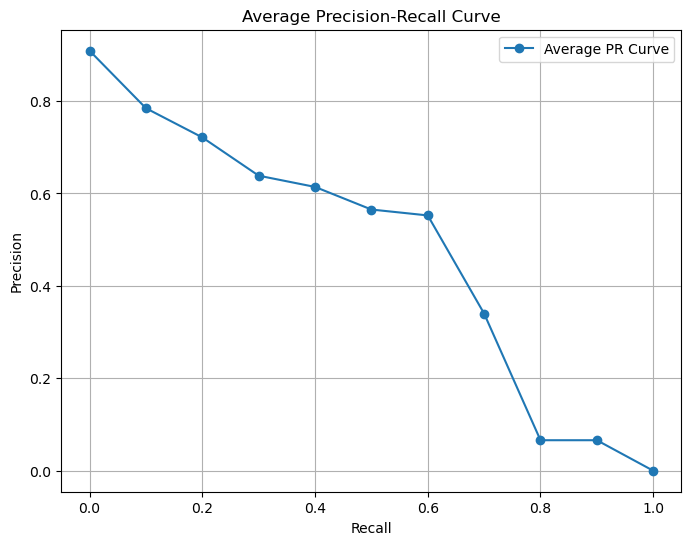

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_precision_recall_curve(topic, ranked_docs, qrels, total_relevant):
    precision = []
    recall = []
    
    rank = 0
    num_relevant_retrieved = 0
    
    for doc, _ in ranked_docs:
        rank += 1
        
        if (topic, doc) in qrels and qrels[(topic, doc)] != 0:
            num_relevant_retrieved += 1
            
        # Calculate precision and recall at this rank
        prec = num_relevant_retrieved / rank
        rec = num_relevant_retrieved / total_relevant
        
        precision.append(prec)
        recall.append(rec)
    
    return precision, recall
    
# Compute PR curve for all queries and average them
recall_levels=11
recall_points = np.linspace(0, 1, recall_levels)  # Recall levels (0.0 to 1.0)
precision_at_recall = {r: [] for r in recall_points}

for query_data in test_queries:
    topic = query_data['title']
    
    # Get ranked documents for the query
    ranked_docs = calculate_bm25(topic, df=df, doc_lengths=doc_lengths)[0:100]
    total_relevant = sum(1 for key in qrels if key[0] == topic and qrels[key] != 0)
    
    if total_relevant == 0:
        continue 
    
    # Get precision-recall for this query
    precision, recall = calculate_precision_recall_curve(topic, ranked_docs, qrels, total_relevant)
    
    # Interpolate precision at fixed recall levels
    for r in recall_points:
        interpolated_precision = max([p for p, rec in zip(precision, recall) if rec >= r], default=0)
        precision_at_recall[r].append(interpolated_precision)

# Compute average precision at each recall point
avg_precision = [np.mean(precision_at_recall[r]) if precision_at_recall[r] else 0 for r in recall_points]

# Plot the average PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall_points, avg_precision, marker='o', label="Average PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Average Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()